In [1]:
!pip install pandas seaborn matplotlib nltk textblob wordcloud vaderSentiment seaborn graphviz
!python -m spacy download en_core_web_sm  

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')

Reddit = pd.read_csv("reduced_reddit_posts.csv")
Reddit = Reddit.dropna(subset=['selftext'])  # Drop rows where selftext is NaN

/Users/elizabethkudriavtsev/miniconda3/bin/python: No module named spacy


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elizabethkudriavtsev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elizabethkudriavtsev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fixing DateTime, Time Distribution

Year
2012     4
2013    18
2014    29
2015    44
2016    93
Name: count, dtype: int64


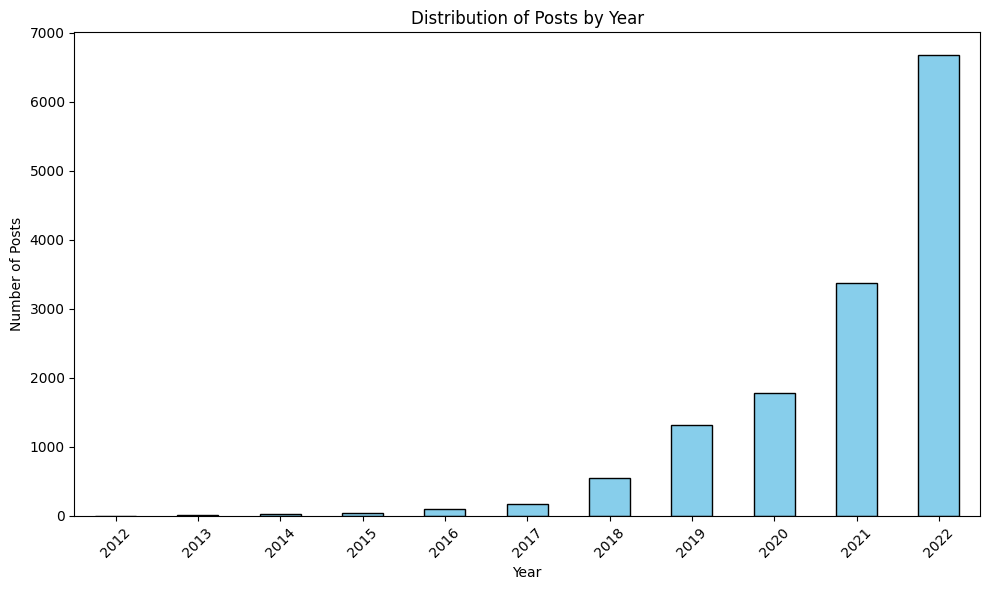

In [2]:
from datetime import datetime

def epoch_to_date(epoch_time):
    """
    Convert epoch time to datetime object with only year, month, and day.

    :param epoch_time: Epoch time in seconds (can be string or number)
    :type epoch_time: int, float, or str
    :return: Date string in the format 'YYYY-MM-DD'
    :rtype: str
    """
    # Check if the input is already a pandas datetime (Timestamp)
    if isinstance(epoch_time, pd.Timestamp):
        return epoch_time.strftime('%Y-%m-%d')
    
    # If epoch_time is numeric (either int or float)
    try:
        epoch_time = float(epoch_time)
        # If it can be converted to a number, treat it as an epoch timestamp
        dt = datetime.fromtimestamp(epoch_time)
    except ValueError:
        # If it cannot be converted to a number, treat it as a date string
        try:
            dt = datetime.strptime(epoch_time, '%Y-%m-%d')  # Adjust the format if necessary
        except ValueError:
            raise ValueError(f"Invalid epoch time or date string: {epoch_time}")
    
    return dt.strftime('%Y-%m-%d')

# Apply the function to the Reddit DataFrame
Reddit["created_utc"] = Reddit["created_utc"].apply(epoch_to_date)
Reddit['created_utc'] = pd.to_datetime(Reddit['created_utc'], errors='coerce')

# Count the number of posts per year
Reddit['Year'] = Reddit['created_utc'].dt.year
posts_per_year = Reddit['Year'].value_counts().sort_index()
print(posts_per_year.head())
# Plot the distribution of posts per year
plt.figure(figsize=(10, 6))
posts_per_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Temporal Analysis

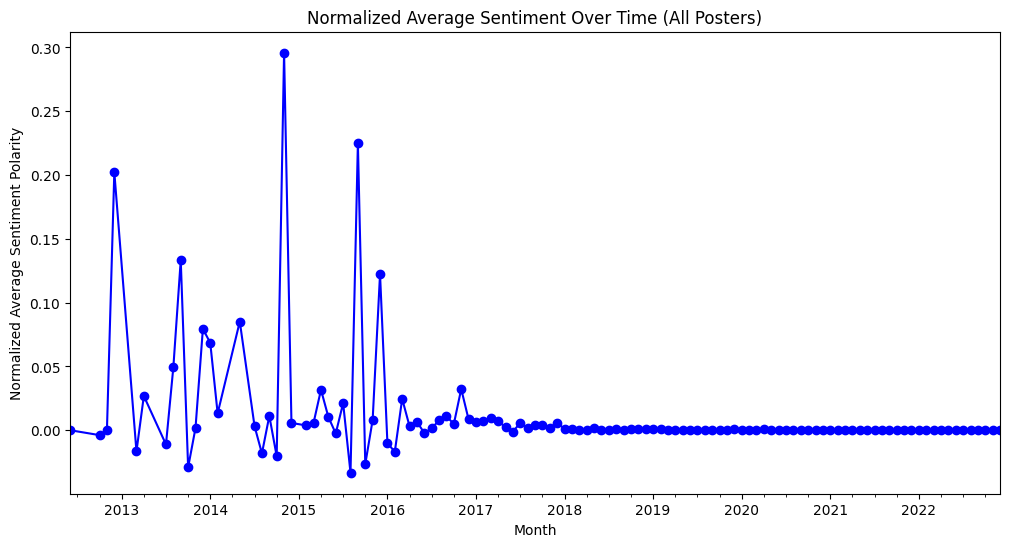

/var/folders/m2/4cg3yx5920q_xr4pt77l79f80000gn/T/ipykernel_6972/8066578.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  repeat_data = repeat_data.groupby('author').apply(calculate_sentiment_trend).reset_index(drop=True)


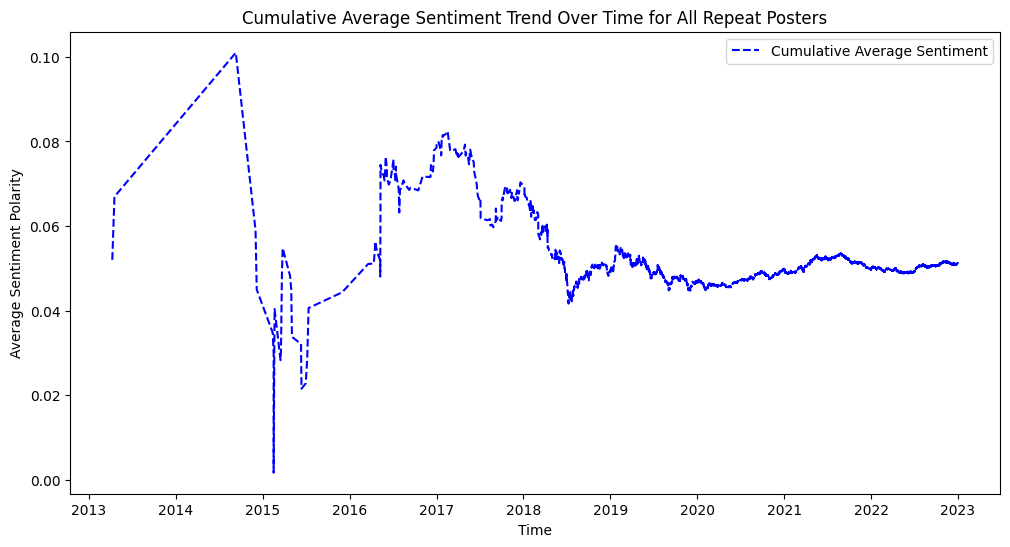

Sentiment_Direction  Decreasing  Increasing  No Change
author                                                
--2021--                   10.0         6.0        1.0
--pjh--                     0.0         2.0        1.0
00uec                       1.0         2.0        1.0
0verther3                   0.0         1.0        1.0
1212zephyr1212              2.0         4.0        1.0
...                         ...         ...        ...
ziggystargazer              2.0         0.0        1.0
zipzangalang                0.0         1.0        1.0
zonule                      0.0         1.0        1.0
zsepthenne                  1.0         1.0        1.0
zweezi                      1.0         1.0        1.0

[1783 rows x 3 columns]


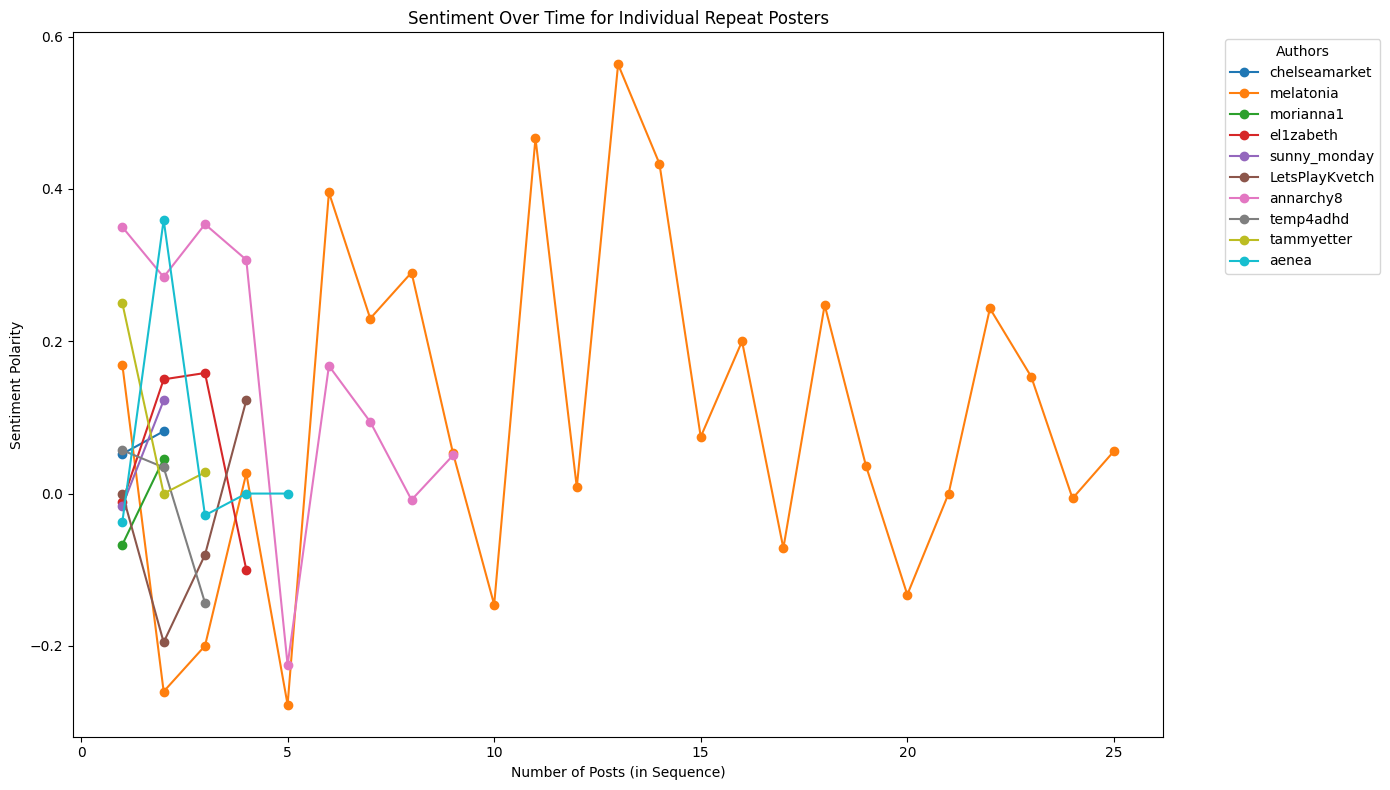

In [3]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Datetime column formatting
Reddit['created_utc'] = pd.to_datetime(Reddit['created_utc'], format="%Y-%m-%dT%H:%M%z")

# Calculate sentiment for each post
Reddit['Sentiment'] = Reddit['selftext'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

### Sentiment Analysis Over Time ###

# Calculate Average Sentiment per Month (before normalization)
Reddit['Month'] = Reddit['created_utc'].dt.to_period('M')
monthly_sentiment = Reddit.groupby('Month')['Sentiment'].mean()

# Normalize sentiment by dividing by the number of posts per month
posts_per_month = Reddit.groupby('Month').size()  # Number of posts per month
normalized_monthly_sentiment = monthly_sentiment / posts_per_month

# Plot Normalized Sentiment Over Time
plt.figure(figsize=(12, 6))
normalized_monthly_sentiment.plot(kind='line', marker='o', color='blue')
plt.title("Normalized Average Sentiment Over Time (All Posters)")
plt.xlabel("Month")
plt.ylabel("Normalized Average Sentiment Polarity")
plt.show()


### Sentiment Analysis of Repeat Posters ###

# Exclude "Guest" authors
reddit_filtered = Reddit[Reddit['author'] != '[deleted]']

# Filter in authors who post more than once
repeat_authors = reddit_filtered['author'].value_counts()
repeat_authors = repeat_authors[repeat_authors > 1].index  # Authors with more than one post
repeat_data = reddit_filtered[reddit_filtered['author'].isin(repeat_authors)]

# Sort posts by author and datetime
repeat_data = repeat_data.sort_values(by=['author', 'created_utc'])

# Calculate sentiment change for each author
def calculate_sentiment_trend(df):
    df = df.copy()  # Avoid potential SettingWithCopyWarning
    df['Sentiment_Change'] = df['Sentiment'].diff()
    return df

# Apply and reset index to avoid ambiguity
repeat_data = repeat_data.groupby('author').apply(calculate_sentiment_trend).reset_index(drop=True)

# Step 6: Calculate the cumulative average sentiment trend over time for all repeat posters
# Sort data by datetime across all repeat posters
repeat_data = repeat_data.sort_values(by='created_utc')

# Calculate cumulative average sentiment over time
repeat_data['Cumulative_Avg_Sentiment'] = repeat_data['Sentiment'].expanding().mean()

# Plot cumulative average sentiment trend for all repeat posters
plt.figure(figsize=(12, 6))
plt.plot(repeat_data['created_utc'], repeat_data['Cumulative_Avg_Sentiment'], label='Cumulative Average Sentiment', color='blue', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Average Sentiment Polarity')
plt.title('Cumulative Average Sentiment Trend Over Time for All Repeat Posters')
plt.legend()
plt.show()

# Set Datetime as the index to make resampling by time easier
repeat_data.set_index('created_utc', inplace=True)

# Step 5: Calculate overall sentiment change direction (increasing or decreasing)
repeat_data['Sentiment_Direction'] = repeat_data['Sentiment_Change'].apply(
    lambda x: 'Increasing' if x > 0 else 'Decreasing' if x < 0 else 'No Change'
)

# Summary of sentiment changes
sentiment_summary = repeat_data.groupby('author')['Sentiment_Direction'].value_counts().unstack().fillna(0)
print(sentiment_summary)


### Plot sentiment of each author over number of posts (over time)###

plt.figure(figsize=(14, 8))

# Optionally, limit the number of authors plotted for readability (e.g., 10 authors)
sample_authors = repeat_data['author'].unique()[:10]  # First 10 repeat authors for demonstration

for author in sample_authors:
    author_data = repeat_data[repeat_data['author'] == author]
    
    # Create a plot of sentiment vs. number of posts for this author
    plt.plot(range(1, len(author_data) + 1), author_data['Sentiment'], marker='o', label=author)

plt.xlabel("Number of Posts (in Sequence)")
plt.ylabel("Sentiment Polarity")
plt.title("Sentiment Over Time for Individual Repeat Posters")
plt.legend(title="Authors", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Repeat Poster info

Summary of Repeat Posters:
Total number of repeat posters: 1783
Number of authors who posted exactly twice: 790
Number of authors who posted exactly three times: 336
Number of authors who posted more than three times: 657


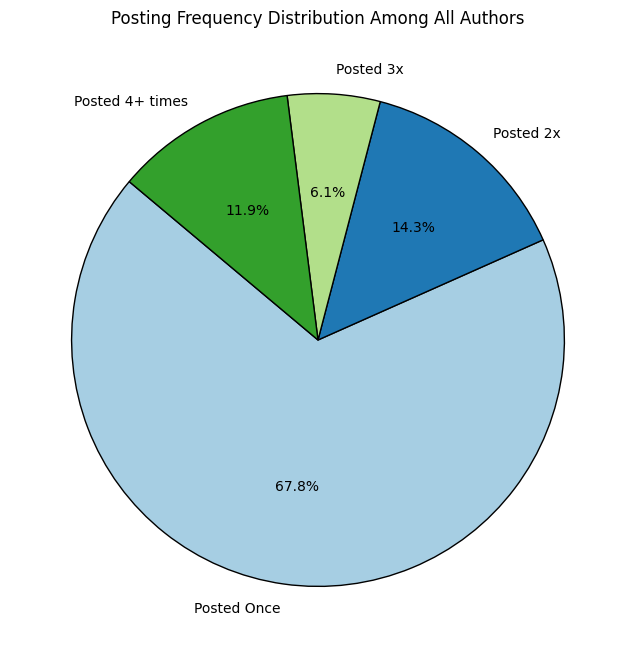

Total New Users: 3752
Total Returning Users: 1784


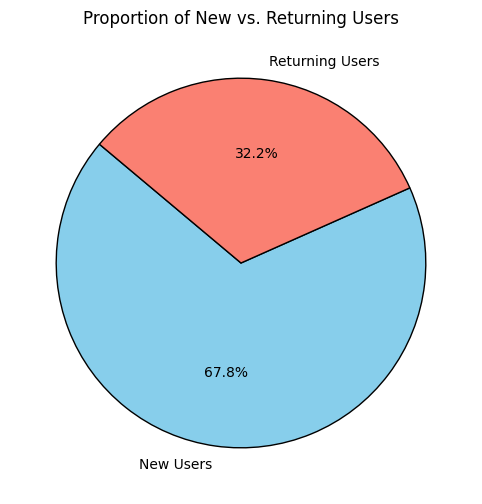

In [5]:
# Count the number of posts for each author
post_counts = repeat_data['author'].value_counts()

# Summary statistics for repeat posters
num_repeat_authors = len(post_counts)  # Total number of repeat posters
twice_posters = (post_counts == 2).sum()  # Authors who posted exactly twice
thrice_posters = (post_counts == 3).sum()  # Authors who posted exactly three times
more_than_thrice_posters = (post_counts > 3).sum()  # Authors who posted more than three times

print("Summary of Repeat Posters:")
print(f"Total number of repeat posters: {num_repeat_authors}")
print(f"Number of authors who posted exactly twice: {twice_posters}")
print(f"Number of authors who posted exactly three times: {thrice_posters}")
print(f"Number of authors who posted more than three times: {more_than_thrice_posters}")

#pie chart of posters
post_counts = Reddit['author'].value_counts()
once_posters = (post_counts == 1).sum()      # Authors who posted exactly once
twice_posters = (post_counts == 2).sum()     # Authors who posted exactly twice
thrice_posters = (post_counts == 3).sum()    # Authors who posted exactly three times
more_than_thrice_posters = (post_counts > 3).sum()  # Authors who posted more than three times


labels = ['Posted Once', 'Posted 2x', 'Posted 3x', 'Posted 4+ times']
sizes = [once_posters, twice_posters, thrice_posters, more_than_thrice_posters]
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c']
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Posting Frequency Distribution Among All Authors")
plt.show()

# Identify the date of the first post for each user
first_post_dates = Reddit.groupby('author')['created_utc'].min()

# Mark users as 'New' if their first post is their only post, otherwise 'Returning'
user_post_counts = Reddit['author'].value_counts()
Reddit['User_Type'] = Reddit['author'].apply(lambda x: 'New' if user_post_counts[x] == 1 else 'Returning')

# Calculate total number of new vs returning users
total_user_counts = Reddit[['author', 'User_Type']].drop_duplicates().value_counts(subset=['User_Type'])
print("Total New Users:", total_user_counts['New'])
print("Total Returning Users:", total_user_counts['Returning'])

plt.figure(figsize=(8, 6))
plt.pie(
    total_user_counts, 
    labels=['New Users', 'Returning Users'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['skyblue', 'salmon'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Proportion of New vs. Returning Users")
plt.show()


Identified Topics:
Topic 1: 0.010*"menopause" + 0.009*"weight" + 0.009*"years" + 0.006*"said" + 0.006*"doctor"
Topic 2: 0.025*"menopause" + 0.023*"https" + 0.019*"amp" + 0.017*"women" + 0.016*"com"
Topic 3: 0.016*"period" + 0.015*"like" + 0.012*"days" + 0.012*"hot" + 0.010*"last"
Topic 4: 0.015*"like" + 0.011*"feel" + 0.009*"know" + 0.008*"get" + 0.008*"life"
Topic 5: 0.016*"hrt" + 0.011*"estrogen" + 0.011*"progesterone" + 0.010*"symptoms" + 0.009*"anyone"


/var/folders/m2/4cg3yx5920q_xr4pt77l79f80000gn/T/ipykernel_6972/1097305316.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  six_month_topic_trends = normalized_monthly_topic_trends.resample('6M').sum()


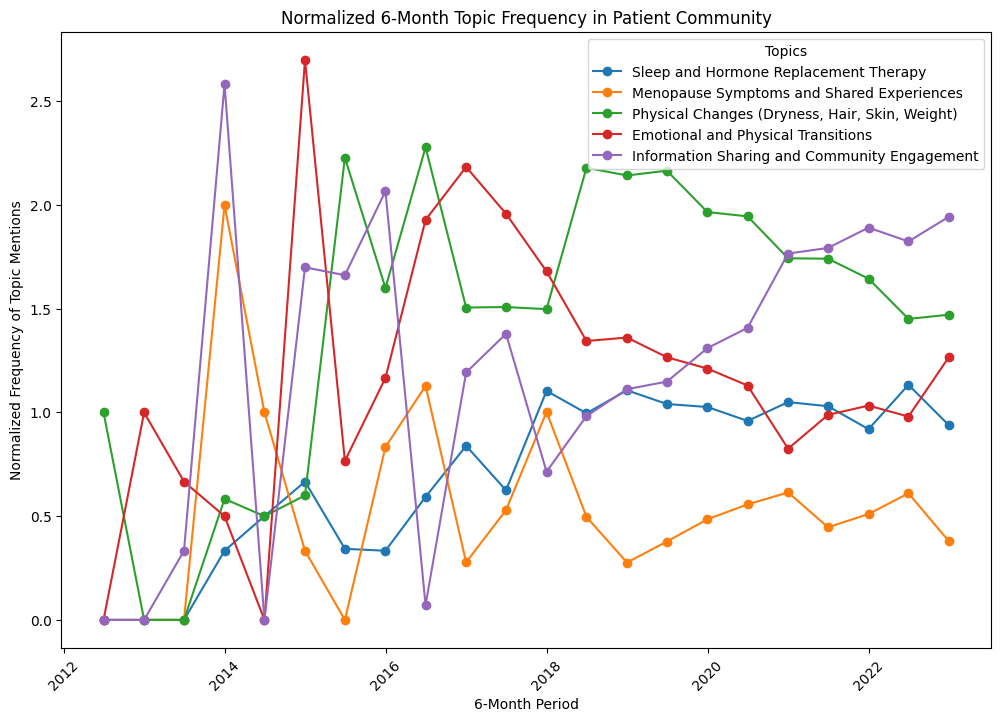

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim import corpora, models

# Text Preprocessing: Clean and tokenize text data
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove stopwords and short words
    return tokens

# Apply preprocessing to each post content
Reddit['Tokens'] = Reddit['selftext'].apply(preprocess)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(Reddit['Tokens'])
corpus = [dictionary.doc2bow(text) for text in Reddit['Tokens']]

# Run LDA topic model (e.g., with 5 topics)
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Print out the topics for review
topics = lda_model.print_topics(num_words=5)
print("Identified Topics:")
for idx, topic in topics:
    print(f"Topic {idx + 1}: {topic}")

# Monthly topic distribution: Calculate frequency of each topic over time
Reddit['Month'] = Reddit['created_utc'].dt.to_period('M')  # Extract month information
Reddit['Topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]  # Assign the most likely topic

# Calculate the number of posts per month
posts_per_month = Reddit.groupby('Month').size()  # Number of posts per month

# Monthly topic trends: Calculate the frequency of each topic per month
monthly_topic_trends = Reddit.groupby(['Month', 'Topic']).size().unstack(fill_value=0)

# Normalize the topic counts by the number of posts in each month
normalized_monthly_topic_trends = monthly_topic_trends.div(posts_per_month, axis=0)

# Resample the monthly topic trends to 6-month periods
normalized_monthly_topic_trends.index = pd.to_datetime(normalized_monthly_topic_trends.index.astype(str))  # Convert period to datetime
six_month_topic_trends = normalized_monthly_topic_trends.resample('6M').sum()

# Define a dictionary to map topic numbers to descriptive labels
topic_labels = {
    0: 'Sleep and Hormone Replacement Therapy',
    1: 'Menopause Symptoms and Shared Experiences',
    2: 'Physical Changes (Dryness, Hair, Skin, Weight)',
    3: 'Emotional and Physical Transitions',
    4: 'Information Sharing and Community Engagement'
}

# Plotting the topic trends over 6-month periods
plt.figure(figsize=(12, 8))
for column in six_month_topic_trends.columns:
    plt.plot(six_month_topic_trends.index, six_month_topic_trends[column], marker='o', label=topic_labels[column])

plt.xlabel('6-Month Period')
plt.ylabel('Normalized Frequency of Topic Mentions')
plt.title('Normalized 6-Month Topic Frequency in Patient Community')
plt.legend(title='Topics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


/var/folders/m2/4cg3yx5920q_xr4pt77l79f80000gn/T/ipykernel_6972/3894027330.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='6M'), 'User_Type'])


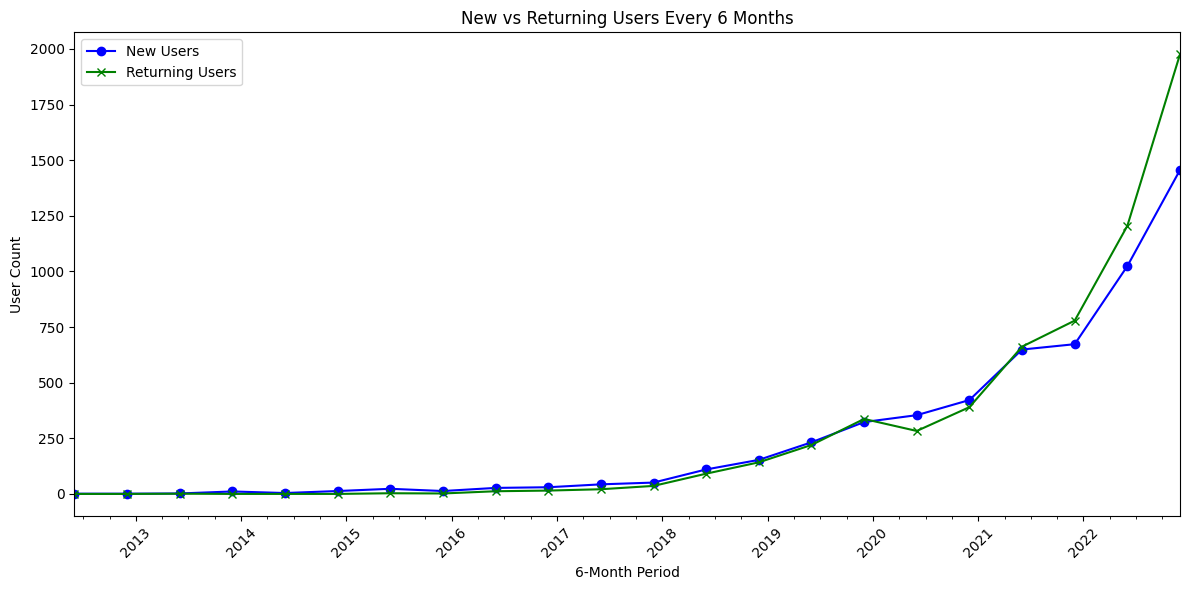

Identified Topics:
Sleep and Hormone Replacement Therapy: 0.010*"menopause" + 0.009*"weight" + 0.009*"years" + 0.006*"said" + 0.006*"doctor"
Menopause Symptoms and Shared Experiences: 0.025*"menopause" + 0.023*"https" + 0.019*"amp" + 0.017*"women" + 0.016*"com"
Physical Changes (Dryness, Hair, Skin, Weight): 0.016*"period" + 0.015*"like" + 0.012*"days" + 0.012*"hot" + 0.010*"last"
Emotional and Physical Transitions: 0.015*"like" + 0.011*"feel" + 0.009*"know" + 0.008*"get" + 0.008*"life"
Information Sharing and Community Engagement: 0.016*"hrt" + 0.011*"estrogen" + 0.011*"progesterone" + 0.010*"symptoms" + 0.009*"anyone"


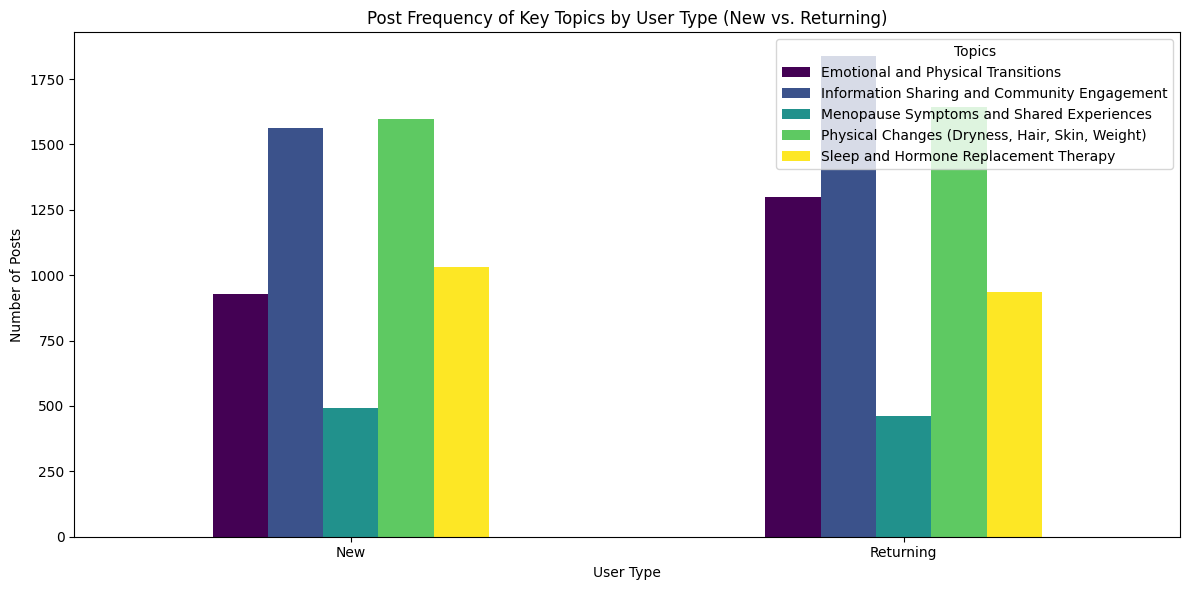

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Datetime' column to pandas datetime
Reddit['created_utc'] = pd.to_datetime(Reddit['created_utc'], format="%Y-%m-%dT%H:%M%z")
Reddit['Month'] = Reddit['created_utc'].dt.to_period('M')
#Bye bYe Guest
Reddit = Reddit[Reddit['author'] != '[deleted]']


Reddit = Reddit[Reddit['author'] != '[deleted]']

# Identify first-time vs returning users
first_posts = Reddit.groupby('author')['created_utc'].min()  # First post date for each author
Reddit['User_Type'] = Reddit.apply(lambda row: 'New' if row['created_utc'] == first_posts[row['author']] else 'Returning', axis=1)

# Group by 6-month period and user type to get counts
six_month_user_type = (
    Reddit.set_index('created_utc')
    .groupby([pd.Grouper(freq='6M'), 'User_Type'])
    .size()
    .unstack(fill_value=0)
)

# Plot the count of new vs returning users every 6 months
plt.figure(figsize=(12, 6))
six_month_user_type['New'].plot(label='New Users', color='blue', marker='o')
six_month_user_type['Returning'].plot(label='Returning Users', color='green', marker='x')
plt.title('New vs Returning Users Every 6 Months')
plt.xlabel('6-Month Period')
plt.ylabel('User Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
from gensim import corpora, models


# Preprocessing function
def preprocess(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove all special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove stopwords and short tokens
    return tokens

# Create dictionary and corpus
dictionary = corpora.Dictionary(Reddit['Tokens'])
corpus = [dictionary.doc2bow(text) for text in Reddit['Tokens']]

# Run LDA
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Assign topics to posts
Reddit['Topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Review topics
print("Identified Topics:")
for idx, topic in lda_model.print_topics(num_words=5):
    print(f"{topic_labels[idx]}: {topic}")

# Map numeric topics to descriptive labels
Reddit['Topic_Label'] = Reddit['Topic'].map(topic_labels)

# Group by user type and topic label, count number of posts
topic_user_type = Reddit.groupby(['User_Type', 'Topic_Label']).size().unstack(fill_value=0)

# Plot frequency of key topics by user type
topic_user_type.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Post Frequency of Key Topics by User Type (New vs. Returning)')
plt.xlabel('User Type')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.legend(title='Topics')
plt.tight_layout()
plt.show()



Time Between Posts by the Same User: 
#For users who post multiple times, measure the intervals between their posts. 
#Shorter intervals might suggest urgent or worsening issues, while longer intervals could indicate less frequent check-ins or resolutions.

In [ ]:
# Filter out authors with only one post
repeat_posters = Reddit[Reddit.duplicated(subset='author', keep=False)]

# Sort by 'Author' and 'Datetime' for calculating time differences
repeat_posters = repeat_posters.sort_values(by=['author', 'created_utc'])

# Calculate the time difference between each post for the same author
repeat_posters['Time_Between_Posts'] = repeat_posters.groupby('author')['created_utc'].diff().dt.total_seconds() / (60 * 60 * 24)  # Convert to days

# Drop rows with NaN values in 'Time_Between_Posts' (first post of each author will have NaN)
repeat_posters = repeat_posters.dropna(subset=['Time_Between_Posts'])

# Calculate average time between posts for each user
avg_time_between_posts = repeat_posters.groupby('author')['Time_Between_Posts'].mean()

# Plot distribution of average time between posts
plt.figure(figsize=(12, 6))
avg_time_between_posts.hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Time Between Posts for Repeat Posters')
plt.xlabel('Average Time Between Posts (days)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()
